## Data loading for default of credit card clients dataset 

To use the data, simply load the pickle file

In [1]:
import pickle
import numpy as np
import pdb
import matplotlib.pyplot as plt
with open("train_test_split.pkl", "br") as fh:
    data = pickle.load(fh)
train_data = data[0]
test_data = data[1]

train_x = train_data[:,:23]
train_y = train_data[:,23] # labels are either 0 or 1
test_x = test_data[:,:23]
test_y = test_data[:,23] # labels are either 0 or 1

# converting the labels to +-1 

In [2]:
train_y = 2*train_y - 1
test_y = 2*test_y -1

# weak classifier

# Parallel Ada Boost Algorithm-1

In [3]:
class Adaboost:
    def __init__(self, train_x, train_y,test_x,test_y):
        self.train_x = train_x 
        self.train_y = train_y
        self.test_x =  test_x
        self.test_y = test_y
        self.feature_len = self.train_x.shape[1]
        self.train_len = self.train_x.shape[0]
        self.test_len =  self.test_x.shape[0]
        self.h_weak_train = self.naive_weak_classifier(self.train_x,j=None)
        self.h_weak_test  = self.naive_weak_classifier(self.test_x,j=None)
        self.M_train,self.M_train_normalized = self.cal_M(train_data=True)
        self.M_test,self.M_test_normalized = self.cal_M(train_data=False)
    # h_j = sign(x_j-m_j)
    def naive_weak_classifier(self,X,j=None):
        #X : nxd 
        #j : jth feature <=d if none then comute H_j = n*d matrix
        # return 
        # h_j = nx1 classifier or H_j  = n*d matrix  
        if j != None:
            X_j = X[:,j]
            M_j = np.median(X_j) 
            h_j_temp  = X_j - M_j
            h_j  = np.where(h_j_temp >= 0, 1, -1)[...,np.newaxis]
            return h_j
        else :
            #print(X.shape)
            M = np.median(X,axis=0)[np.newaxis,...]
            #print(M.shape) 
            H_j_temp  = X - M
            H  = np.where(H_j_temp >= 0, 1, -1)
            return H
    def cal_loss(self,w_t):
        H_train = np.multiply(w_t.squeeze(),self.h_weak_train )
        H_test = np.multiply(w_t.squeeze(),self.h_weak_test)
        # calculating the training-error testing-error
        train_pred = np.sum(H_train,axis=1)
        test_pred  = np.sum(H_test,axis=1)
        training_error = (1/self.train_len)*np.sum(np.where(np.multiply(self.train_y,train_pred) <= 0, 1,0))
        testing_error  = (1/self.test_len)*np.sum(np.where(np.multiply(self.test_y,test_pred) <= 0, 1,0))
        # caluclating loss
        train_loss_t = np.sum(np.exp(-self.M_train_normalized@w_t))
        test_loss_t = np.sum(np.exp(-self.M_test_normalized@w_t))
        return training_error,testing_error,train_loss_t,test_loss_t
    
    
    def cal_M(self,naive_weak_classifier=True,train_data=True):
        if train_data:
            data_x = self.train_x
            target_y = self.train_y 
            H = self.h_weak_train
        else:
            data_x = self.test_x
            target_y = self.test_y
            H = self.h_weak_test

        M = np.multiply(target_y[...,np.newaxis],H).astype(np.float32)
        M_sum_j  = np.sum(M , axis=0)
        M_normalized = M/M_sum_j
        return M,M_normalized
    def do_plot(self,train_error,train_loss,test_error,test_loss):
        fig, ax = plt.subplots(figsize = (10, 5))
        plt.title('naive-weak-classifier')
        iteration = np.arange(len(train_error))
        ax2 = ax.twinx()
        ax.plot(iteration, train_error, color = 'g',label ="train-error")
        ax.plot(iteration,test_error,linestyle='dashed' ,color = 'r',label = "test-error")
        ax.set_xlabel('iteration', color = 'r')
        ax.set_ylabel('train/test-error', color = 'g')
        ax.legend(loc='upper center', shadow=True)
        # secondary y-axis label
        ax2.plot(iteration,train_loss, color = 'b' , label="train-loss")
        ax2.set_ylabel('train_loss', color = 'b')
        ax2.legend(loc='upper right', shadow=True)
        # defining display layout 
        plt.tight_layout()
        
        # show plot
        plt.show()
    def get_alpha_t(self,epsi_t,gamma_t,is_parallel = True):
        if is_parallel:
            alpha_t = np.ones((self.feature_len,1))
            return alpha_t
        else:
            j_pick = np.argmax(  np.abs(epsi_t**0.5 - gamma_t**0.5)  )
            
            alpha_t = np.zeros((self.feature_len,1))
            alpha_t[j_pick]  = 1 
            
            return alpha_t
    def train(self,w0 ,p0,max_pass=300, train_data=True, parallel_adaboost = True):
        if train_data==True:
            data_len = self.train_len
        M = self.M_train_normalized
        w_t = w0
        p_t = p0
        M_positive = np.maximum(M,0)
        M_negative = np.abs(M) - M_positive
        
        train_loss = []
        train_error  =[]
        test_loss = []
        test_error =[]

        for i in range(max_pass):
            training_error_t,testing_error_t,train_loss_t,test_loss_t = self.cal_loss(w_t)
            train_error.append(training_error_t)
            train_loss.append(train_loss_t)
            test_error.append(testing_error_t)
            test_loss.append(test_loss_t)
            print(training_error_t,testing_error_t,train_loss_t,test_loss_t)
            p_t = np.divide(p_t,np.sum(p_t))
            epsi_t = np.transpose(M_negative)@p_t 
            gamma_t = 1- epsi_t
            #print(gamma_t.shape , epsi_t.shape)
            beta_t_temp = np.divide(gamma_t,epsi_t)
            beta_t = np.log(beta_t_temp)
            alpha_t = self.get_alpha_t(epsi_t,gamma_t,is_parallel = parallel_adaboost) # Sequential-Adaboost
            w_t = w_t + np.multiply(alpha_t,beta_t)
            p_t = np.multiply(p_t,np.exp(-M@(np.multiply(alpha_t,beta_t))))
        return w_t,train_error,train_loss,test_error,test_loss


# calling Ada BOOST

In [4]:
adaboost_object = Adaboost(train_x=train_x,train_y=train_y ,test_x=test_x ,test_y=test_y )
w_final,train_error,train_loss,test_error,test_loss = adaboost_object.train(w0 = np.zeros((train_x.shape[1],1)),p0 = np.ones((train_x.shape[0],1)),max_pass=300, train_data=True,parallel_adaboost = True)
print(w_final.shape)


1.0 1.0 20000.0 10000.0
0.5393 0.5435 19958.02955746738 10006.22746784035
0.53935 0.5436 20168.518402209207 10378.838295437401
0.5393 0.5435 20623.15882772454 11159.074411717167
0.5393 0.5435 21331.017443621164 12446.548883091615
0.53925 0.5434 22318.373140065538 14423.26667568557
0.53915 0.5434 23629.998893531578 17399.351845363784
0.53915 0.5434 25331.801433659602 21893.34952562661
0.5392 0.5434 27514.901293778283 28770.09524771203
0.53915 0.5435 30301.408408864627 39475.97910682623
0.5392 0.5435 33852.33862941064 56440.03575509619
0.53925 0.5435 38378.327223988825 83758.28311469578
0.5396000000000001 0.5434 44154.030727623154 128362.94630989023
0.5396500000000001 0.5435 51537.38514680063 202023.24728978635
0.5397000000000001 0.5435 60995.23935541537 324774.6051688499
0.5396000000000001 0.5432 73137.35136130286 530805.0893802678
0.5396000000000001 0.5432 88761.37147488819 878574.8416305941
0.5396000000000001 0.5433 108912.29583133763 1468236.9575878019
0.5396500000000001 0.5434 13496

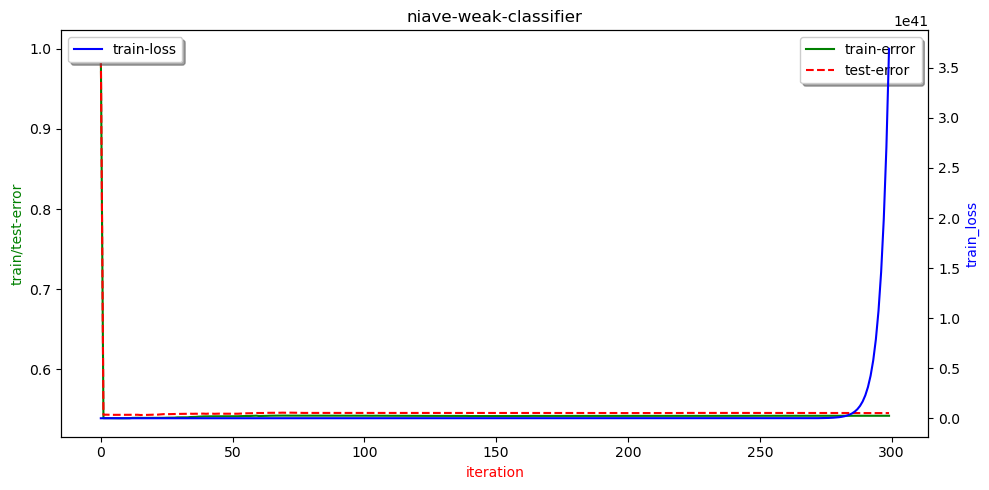

In [6]:
adaboost_object.do_plot(train_error,train_loss,test_error,test_loss)